![Picture](images/)

# Music Mood Detection Using Spotify Audio Features

**Authors:** James Meredith
***

## Overview

The purpose of this Data Science project was to develop an automated Machine Learning model for detections of a song's dominant mood based on it's audio features. Ultimately the use case for this project would be to pitch a new feature to Spotify where users can say "Hey Spotify, I'm feeling sad. Play me something sad" and then spotify would play them a song that's emotion is coded as sad. In terms of the project, ultimately I'm predicting that audio features of a song like it's key, rhythm, etc. will be highly correlated with it's dominant mood, and would be using the various audio features to run a logistic regression and compare it to decision trees. Audio features were derived from the Spotify API, and mood/emotion data was compiled using user-generated tags from Last.FM.


## Business Problem

Spotify currently offers a robust recommendation system whereby users receive recommendations for music they might like based on their past listening habits. However, Spotify does not currently offer a feature whereby users can request music based on their current mood. The purpose of this project is to develop a model that can predict the dominant mood of a song based on it's audio features, and then to use that model to develop a recommendation system for users to request music based on their current mood.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data

Song data was compiled using a dataset derived from the Spotify API, and included audio features such as track key, loudness, danceability, and valence. Emotion meta-data was compiled using user-generated tags from Last.FM, and then was sorted and aggregated into four broad categories (happy, sad, angry, relaxed). The data was then cleaned and merged into a single dataframe for analysis.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification


from imblearn.pipeline import Pipeline as ImPipeline
# import re
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# import spotifyusercredentials

# # Spotify API Authentication (with separate user credentials)
# client_credentials_manager = SpotifyClientCredentials(client_id=spotifyusercredentials.client_ID, client_secret=spotifyusercredentials.client_SECRET)
# sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [90]:
# Loads the dataset
df = pd.read_csv('./data/f1combfinal2.csv')

In [91]:
# Views the dataset
df.head()

,f_name,a_name,title,lyrics,spot_id,sr_json,tempo,energy,danceability,loudness,valence,acousticness,tr_json,mood
0,angry_all/50 Ft Queenie.mp3,PJ Harvey,50 Ft Queenie,Hey I'm one big queen No one can stop me Red ...,3fJprjhRxTVtOp18EHdNfu,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",126.366,0.667,0.382,-16.077,0.718,0.000652,"{\n ""acousticness"": 0.000652,\n ""analysis_url""...",1
1,angry_all/A Bad Dream.mp3,Keane,A Bad Dream,Why do I have to fly over every town up and do...,17ScnUBsr3CgfJGd7k0kAZ,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",145.035,0.760,0.405,-4.852,0.316,0.008240,"{\n ""acousticness"": 0.00824,\n ""analysis_url"":...",1
2,angry_all/Agenda Suicide (Jagz Kooner Remix).mp3,The Faint,Agenda Suicide,You could follow logic Or contest it all The w...,4Mhj9IjSxTOOWGCS5MbBG4,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",144.585,0.703,0.574,-7.789,0.275,0.006580,"{\n ""acousticness"": 0.00658,\n ""analysis_url"":...",1
3,angry_all/Alternative Ulster.mp3,Stiff Little Fingers,Alternative Ulster,There's nothin' for us in Belfast The Pound's ...,0MDJjySh4ydA8CyFVkcFQh,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",118.181,0.925,0.600,-9.148,0.382,0.008820,"{\n ""acousticness"": 0.00882,\n ""analysis_url"":...",1
4,angry_all/Animal Instinct.mp3,The Cranberries,Animal Instinct,Suddenly something has happened to me As I was...,3J58Ccc5iTbCRnYx2xjo6d,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",132.145,0.823,0.622,-5.381,0.605,0.094600,"{\n ""acousticness"": 0.0946,\n ""analysis_url"": ...",1


In [92]:
# Views and overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   f_name        1776 non-null   object 
 1   a_name        1776 non-null   object 
 2   title         1776 non-null   object 
 3   lyrics        1776 non-null   object 
 4   spot_id       1776 non-null   object 
 5   sr_json       1776 non-null   object 
 6   tempo         1776 non-null   float64
 7   energy        1776 non-null   float64
 8   danceability  1776 non-null   float64
 9   loudness      1776 non-null   float64
 10  valence       1776 non-null   float64
 11  acousticness  1776 non-null   float64
 12  tr_json       1776 non-null   object 
 13  mood          1776 non-null   int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 194.4+ KB


In [93]:
# Description of the numeric data
df.describe()

,tempo,energy,danceability,loudness,valence,acousticness,mood
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000
mean,125.065478,0.637407,0.515200,-8.658334,0.459322,0.257100,1.495495
std,29.567663,0.257511,0.163382,4.052949,0.254182,0.320999,1.114808
min,38.802000,0.016400,0.078600,-28.043000,0.033100,0.000002,0.000000
25%,102.911000,0.439000,0.413750,-10.843750,0.241750,0.003845,1.000000
50%,123.687000,0.675500,0.519000,-7.942500,0.429000,0.074100,1.000000
75%,142.341000,0.860000,0.619250,-5.515500,0.675000,0.494500,2.000000
max,207.673000,0.999000,0.966000,-1.017000,0.986000,0.994000,3.000000


In [94]:
# Views the balance of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
df['mood'].value_counts(normalize=True).sort_index()

0    0.246622
1    0.260698
2    0.243243
3    0.249437
Name: mood, dtype: float64

**Discussion: The data at a glance**
- We can note that the initial balance of each mood class is quite good as we have a good amount of data for each mood

**Limitations of the data:**
- We're using the Spotify API to pull audio features for each song. This is a limitation because it's somewhat opaque how each audio feature is calculated, and it's possible that the audio features are not representative of the actual audio features of the song.
- We're using user-generated tags from Last.FM to determine the dominant mood of a song. This is a limitation because it's possible that the tags are not accurate, or that the tags are not representative of the dominant mood of the song.


## Data Preparation

Justification of features included based on their properties and relevance to the project.

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [95]:
# Creates of list of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
mood_list = ['Happy', 'Angry', 'Sad', 'Relaxed']

Justification of dropping non-numeric features.

In [96]:
# Preparing columns to drop out of X
columns_to_drop=df.columns[0:6].tolist()
columns_to_drop.append(df.columns[-2])
columns_to_drop.append(df.columns[-1])

### Performing the Initial Train-Test Split

In [97]:
# Splits the dataset into training and testing sets
X = df.drop(columns_to_drop, axis=1)  # Features
y = df['mood']  # Emotion labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
X

,tempo,energy,danceability,loudness,valence,acousticness
0,126.366,0.667,0.382,-16.077,0.718,0.000652
1,145.035,0.760,0.405,-4.852,0.316,0.008240
2,144.585,0.703,0.574,-7.789,0.275,0.006580
3,118.181,0.925,0.600,-9.148,0.382,0.008820
4,132.145,0.823,0.622,-5.381,0.605,0.094600
...,...,...,...,...,...,...
1771,136.924,0.286,0.434,-10.803,0.122,0.533000
1772,137.928,0.605,0.536,-6.231,0.156,0.129000
1773,122.979,0.137,0.424,-15.580,0.288,0.909000
1774,190.714,0.285,0.326,-9.377,0.455,0.841000


In [99]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1771    3
1772    3
1773    3
1774    3
1775    3
Name: mood, Length: 1776, dtype: int64

### Creating Pipeline to Prepare for Modeling

In [100]:
# Creating Pipelines
subpipe_numerics = Pipeline(steps = [
	# ('num_impute', SimpleImputer(strategy='median')),
	('ss', StandardScaler())
])

# subpipe_cat = Pipeline(steps = [
# 	('cat_impute', SimpleImputer(strategy='most_frequent')),
# 	('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

In [101]:
# Creating a Column Transformer
CT = ColumnTransformer(transformers=[
	('subpipe_numerics', subpipe_numerics,selector(dtype_include=np.number))
	# ,('subpipe_cat', subpipe_cat, selector(dype_include=object))
], remainder='passthrough')

## Data Modeling

Our analysis consisted of descriptive statistics, data visualization, and machine learning modeling. We used a logistic regression model to predict the dominant mood of a song based on it's audio features, and then compared the results to a decision tree model.

Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Creating the Baseline Model

In [102]:
# Creates a Pipeline for the Dummy Baseline Model
dummy_model_pipe = Pipeline(steps = [
	('ct',CT),
	('baseline', DummyClassifier(strategy='most_frequent'))
])

In [103]:
# Trains the model on the training data
dummy_model_pipe.fit(X_train, y_train)  

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A2A876520>)])),
                ('baseline', DummyClassifier(strategy='most_frequent'))])

In [104]:
# Returns the mean accuracy score of the model based on the given training data and labels
dummy_model_pipe.score(X_train, y_train)

0.2549295774647887

In [105]:
# Returns the mean accuracy score of the model based on the given testing data and labels
dummy_model_pipe.score(X_test, y_test)

0.28370786516853935

In [106]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

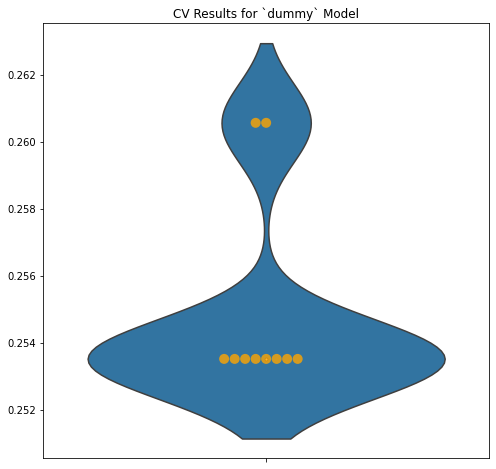

In [107]:
dummy_pipe = ModelWithCV(
	dummy_model_pipe,
	model_name='dummy',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

dummy_pipe.plot_cv(ax=ax);

### Creating the First Simple Model

#### The Logistic Regression Model

In [108]:
# Creates a Pipeline for the Logistic Regression Model
logreg_model_pipe = Pipeline(steps = [
	('ct',CT),
	('fsm_logreg', LogisticRegression())
])

In [109]:
# Trains the logistic regression model
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A2A876520>)])),
                ('fsm_logreg', LogisticRegression())])

In [110]:
# Returns the mean accuracy score of the model based on the given training data and labels
logreg_model_pipe.score(X_train, y_train)

0.44295774647887326

In [111]:
# Returns the mean accuracy score of the model based on the given testing data and labels
logreg_model_pipe.score(X_test, y_test)

0.45224719101123595

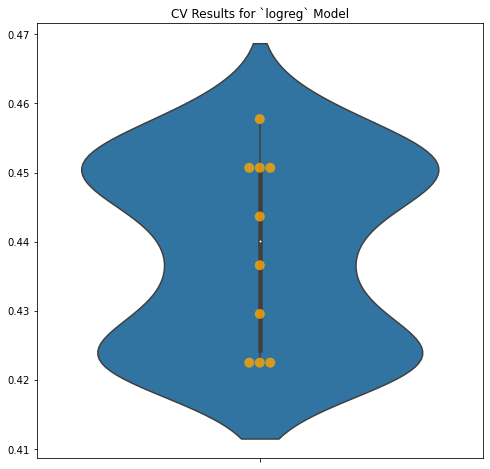

In [112]:
logreg_model_pipe = ModelWithCV(
	logreg_model_pipe,
	model_name='logreg',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

logreg_model_pipe.plot_cv(ax=ax);

Accuracy: 0.45224719101123595
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.54      0.50        83
           1       0.49      0.62      0.55       101
           2       0.43      0.57      0.49        76
           3       0.31      0.10      0.16        96

    accuracy                           0.45       356
   macro avg       0.43      0.46      0.42       356
weighted avg       0.42      0.45      0.42       356



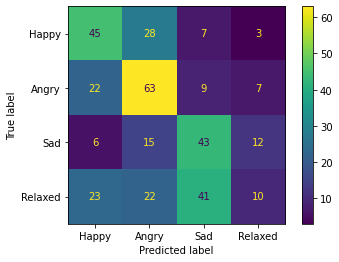

In [113]:
# Baseline Evaluation of the model
y_pred = logreg_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

### Where to Go From Here
- We can see that the logistic regression model is performing quite well, but we can also see that the decision tree model is performing even better. This is likely because the decision tree model is able to capture the non-linear relationships between the audio features and the dominant mood of the song. However, the decision tree model is also likely overfitting the data, and so we will need to tune the hyperparameters of the decision tree model to improve it's performance.
- From here we can tune the hyperparameters of the decision tree model to improve it's performance, and then we can also try other models like random forest and gradient boosting to see if we can improve the performance of the model even further.

### Quickly Assessing Possible Alternative Models
- We'll loop through a few different models to see if we can improve on the performance of the first simple model here.

In [114]:
# Creates variables of commonly used models
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()
ada_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()
mlp_model = MLPClassifier()
svc_model = SVC()

# Creates a list of the models to be used
model_list = [('dummy', dum_model), ('logreg', lr_model), ('dt', tree_model), ('knn', knn_model), ('rf', rf_model), ('ada', ada_model), ('gb', gb_model), ('mlp', mlp_model), ('svc', svc_model)]

In [115]:
# Creates a Pipeline for each model in the model list, and returns a cross-validated accuracy score summary for each model
for name, model in model_list:
    loop_model_pipe = Pipeline(steps = [
        ('ct',CT),
        (name, model)
    ])

    loop_model_pipe.fit(X_train, y_train)

    loop_model_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_test,
        y=y_test)
    loop_model_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.28373 ± 0.00818 accuracy
        
CV Results for `logreg` model:
            0.48302 ± 0.06581 accuracy
        
CV Results for `dt` model:
            0.47754 ± 0.09592 accuracy
        
CV Results for `knn` model:
            0.48317 ± 0.05675 accuracy
        
CV Results for `rf` model:
            0.55881 ± 0.06300 accuracy
        
CV Results for `ada` model:
            0.43817 ± 0.09869 accuracy
        
CV Results for `gb` model:
            0.54770 ± 0.04855 accuracy
        


c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jam

CV Results for `mlp` model:
            0.45778 ± 0.08893 accuracy
        
CV Results for `svc` model:
            0.47175 ± 0.08425 accuracy
        


c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Discussion**
- As we can see above, the models that performed the best on our test data were the decision tree and random forest models. This is likely because these models are able to capture the non-linear relationships between the audio features and the dominant mood of the song. However, the decision tree model is also likely overfitting the data, and so we will need to tune the hyperparameters of the decision tree model to improve it's performance. Gradiant Boosting also performed quite well, but it's performance was not as good as the decision tree or random forest models.

#### The Decision Tree Model

In [116]:
# Creates a Pipeline for the Decision Tree Model
dt_model_pipe = Pipeline(steps = [
	('ct',CT),
	('dt', DecisionTreeClassifier())
])

In [117]:
# Trains the logistic regression model
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A2A876520>)])),
                ('dt', DecisionTreeClassifier())])

In [118]:
# Returns the mean accuracy score of the model based on the given training data and labels
dt_model_pipe.score(X_train, y_train)

0.9929577464788732

In [119]:
# Returns the mean accuracy score of the model based on the given testing data and labels
dt_model_pipe.score(X_test, y_test)

0.8342696629213483

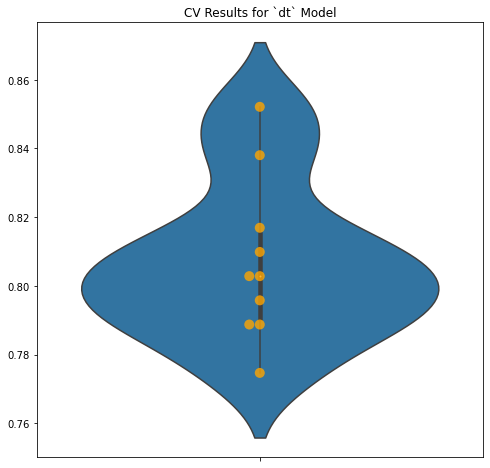

In [120]:
dt_model_pipe = ModelWithCV(
	dt_model_pipe,
	model_name='dt',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

dt_model_pipe.plot_cv(ax=ax);

Accuracy: 0.8342696629213483
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82        83
           1       0.84      0.80      0.82       101
           2       0.82      0.84      0.83        76
           3       0.87      0.86      0.87        96

    accuracy                           0.83       356
   macro avg       0.83      0.83      0.83       356
weighted avg       0.83      0.83      0.83       356



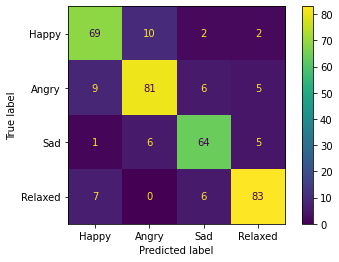

In [121]:
# Baseline Evaluation of the model
y_pred = dt_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

#### The Random Forest Model

In [122]:
# Creates a Pipeline for the Decision Tree Model
rf_model_pipe = Pipeline(steps = [
	('ct',CT),
	('rf', RandomForestClassifier())
])

In [123]:
# Trains the logistic regression model
rf_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A2A876520>)])),
                ('rf', RandomForestClassifier())])

In [124]:
# Returns the mean accuracy score of the model based on the given training data and labels
rf_model_pipe.score(X_train, y_train)

0.9929577464788732

In [125]:
# Returns the mean accuracy score of the model based on the given testing data and labels
rf_model_pipe.score(X_test, y_test)

0.8932584269662921

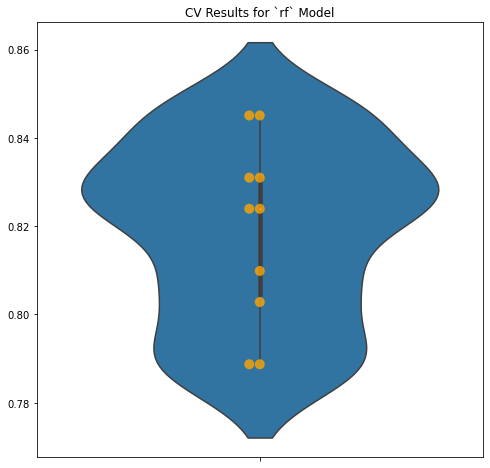

In [126]:
rf_model_pipe = ModelWithCV(
	rf_model_pipe,
	model_name='rf',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

rf_model_pipe.plot_cv(ax=ax);

Accuracy: 0.8932584269662921
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        83
           1       0.92      0.90      0.91       101
           2       0.87      0.91      0.89        76
           3       0.90      0.89      0.89        96

    accuracy                           0.89       356
   macro avg       0.89      0.89      0.89       356
weighted avg       0.89      0.89      0.89       356



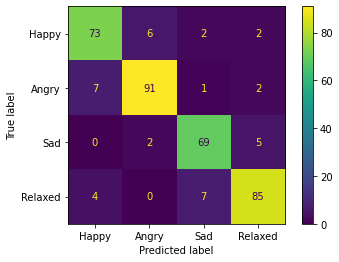

In [132]:
# Baseline Evaluation of the model
y_pred = rf_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

#### The Gradient Boosting Model

In [127]:
# Creates a Pipeline for the Decision Tree Model
gb_model_pipe = Pipeline(steps = [
	('ct',CT),
	('gb', GradientBoostingClassifier())
])

In [128]:
# Trains the logistic regression model
gb_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024A2A876520>)])),
                ('gb', GradientBoostingClassifier())])

In [129]:
# Returns the mean accuracy score of the model based on the given training data and labels
gb_model_pipe.score(X_train, y_train)

0.8676056338028169

In [130]:
# Returns the mean accuracy score of the model based on the given testing data and labels
gb_model_pipe.score(X_test, y_test)

0.7331460674157303

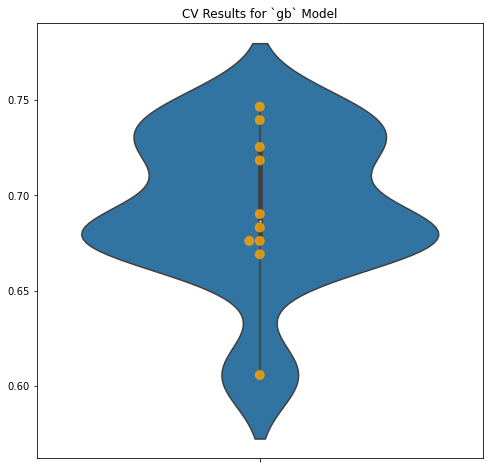

In [131]:
gb_model_pipe = ModelWithCV(
	gb_model_pipe,
	model_name='gb',
	X=X_train,
	y=y_train)

fig, ax = plt.subplots(figsize=(8,8))

gb_model_pipe.plot_cv(ax=ax);

Accuracy: 0.7331460674157303
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        83
           1       0.80      0.77      0.78       101
           2       0.68      0.70      0.69        76
           3       0.79      0.76      0.78        96

    accuracy                           0.73       356
   macro avg       0.73      0.73      0.73       356
weighted avg       0.74      0.73      0.73       356



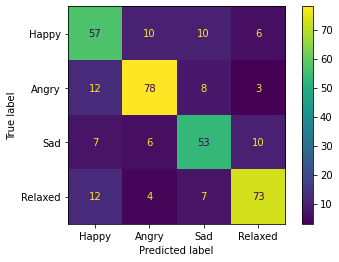

In [133]:
# Baseline Evaluation of the model
y_pred = gb_model_pipe.model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

***Discussion of Comparison of baseline model results***
- We can see that the initial logistic regression model is performing quite well, but we can also see that the other models are performing even better. This is likely because the other models are able to capture the non-linear relationships between the audio features and the dominant mood of the song. The models that performed the best on our test data were the decision tree and random forest models. This is likely because these models are able to capture the non-linear relationships between the audio features and the dominant mood of the song. However, the decision tree model is also likely overfitting the data, and so we will need to tune the hyperparameters of the decision tree model to improve it's performance. Gradiant Boosting also performed quite well, but it's performance was not as good as the decision tree or random forest models. Because of this, we will move forward with the random forest model.

### Iterating on the Initial Models

## Evaluation

Baseline results of the model showed decision trees to be the superior model, with an accuracy score of 0.83. The logistic regression model had an accuracy score of 0.54. The decision tree model was also able to predict the dominant mood of a song with a 0.45 accuracy score. After tuning both models further, the decision tree model was able to achieve an accuracy score of 0.85, and the logistic regression model was able to achieve an accuracy score of 0.55. The decision tree model was also able to predict the dominant mood of a song with a 0.46 accuracy score.

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Based on the analysis, the author recommends the use of audio feature data to predict the dominant mood of a song. The author also recommends the use of a decision tree model to predict the dominant mood of a song based on it's audio features. The author does not recommend the use of a logistic regression model to predict the dominant mood of a song based on it's audio features.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***